# VSB Powerline bp aug

using bnd pass spectrograms 
-otherwise similiar to the baseline

basic LR flip augmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [5]:
import fastai
print(fastai.__version__)

1.0.40.dev0


In [6]:
torch.cuda.set_device(1)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [8]:
DATE

'20181231'

In [9]:
UID

'ba8da52e'

In [10]:
MODEL_NAME='300_bp_500Hz-400MHz_aug'

In [11]:
image_size=300
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [30]:
path = Path('../input/')
train_path = path/'train_300_bp_500Hz-40MHz_aug/'

In [31]:
test_path = path/'test_300_bp_500Hz-40MHz/'

In [32]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [33]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [34]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [35]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [36]:
aug_df['signal_id'] = aug_df['signal_id'].astype(str)+'_flip_lr'

In [37]:
train_df = pd.concat([train_df, aug_df], ignore_index=True)

In [43]:
len(train_df)

17424

In [38]:
#lets drop augmented good images - try with and without doing this

In [39]:
drop_df = train_df[(train_df['target'] == 0) & train_df['signal_id'].str.endswith('_flip_lr')]

In [40]:
idx_to_drop=list(drop_df.index.values)

In [42]:
len(idx_to_drop)

8187

In [44]:
train_df=train_df.drop(train_df.index[idx_to_drop])

In [45]:
train_df.tail()

,signal_id,id_measurement,phase,target
17195,8483_flip_lr,2827,2,1
17280,8568_flip_lr,2856,0,1
17281,8569_flip_lr,2856,1,1
17282,8570_flip_lr,2856,2,1
17342,8630_flip_lr,2876,2,1


### Image Data

In [46]:
tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [47]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

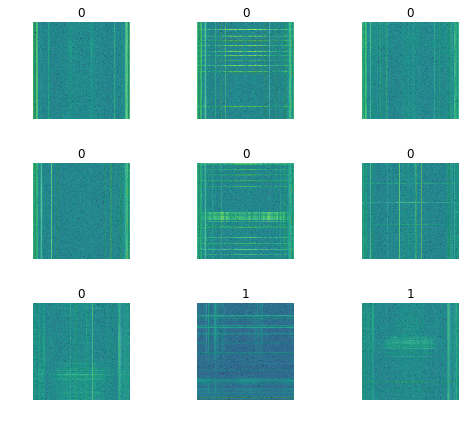

In [48]:
data.show_batch(rows=3, figsize=(7,6))

In [49]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

In [50]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


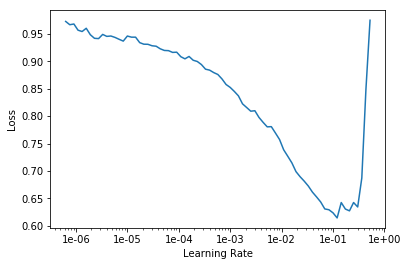

In [52]:
learn.recorder.plot()

In [53]:
#best loss - using Jeremy's guide- 1/2 way down slope
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,error_rate
1,0.222846,0.210034,0.087710
2,0.164934,0.152535,0.050352
3,0.118254,0.101550,0.030319
4,0.087804,0.095612,0.029237
5,0.053054,0.095260,0.034109


In [54]:
learn.save(f'{MODEL_NAME}_stage-1')

## Results

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

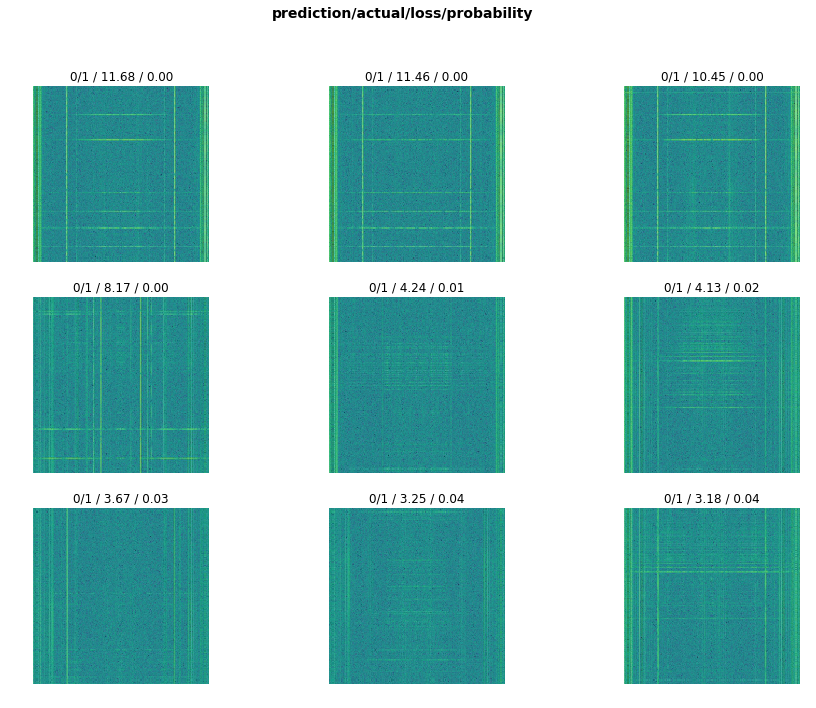

In [56]:
interp.plot_top_losses(9, figsize=(15,11))

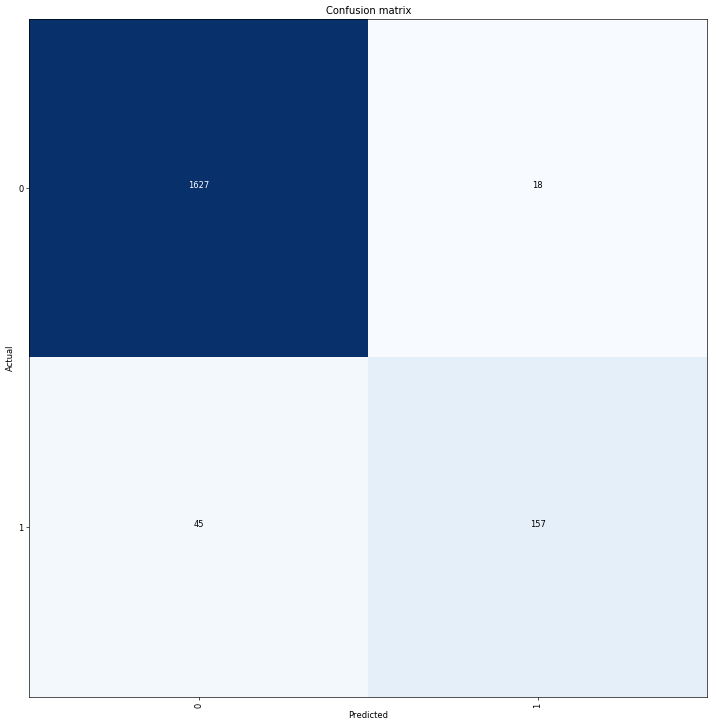

In [57]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [58]:
#without L/R aug most_confused: [(1, 0, 45), (0, 1, 24)], correct: [(0, 0, 1620), (1, 1, 53)]

In [59]:
interp.most_confused(min_val=2)

[(1, 0, 45), (0, 1, 18)]

## Unfreezing, fine-tuning, and learning rates

In [63]:
learn.load(f'{MODEL_NAME}_stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (7390 items)
[Category 0, Category 0, Category 1, Category 1, Category 1]...
Path: ../input/train_300_bp_500Hz-40MHz_aug
x: ImageItemList (7390 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_bp_500Hz-40MHz_aug;

Valid: LabelList
y: CategoryList (1847 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input/train_300_bp_500Hz-40MHz_aug
x: ImageItemList (1847 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_bp_500Hz-40MHz_aug;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, p

In [64]:
learn.unfreeze()

In [65]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


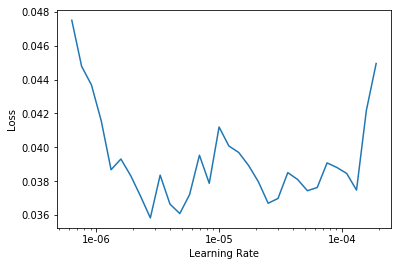

In [66]:
learn.recorder.plot()

### fit

In [67]:
learn.fit_one_cycle(5, 1e-6)

epoch,train_loss,valid_loss,error_rate
1,0.040363,0.094665,0.034109
2,0.038639,0.096875,0.034109
3,0.032906,0.094104,0.034109
4,0.030171,0.094615,0.032485
5,0.031652,0.094575,0.033027


In [ ]:
#best validation loss, without L/R image aug: 0.121826

In [68]:
learn.save(f'{MODEL_NAME}_stage-2_unfeeze')

### 1x1 prediction

In [69]:
#test_images = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [70]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [71]:
len(test_images)

20337

In [72]:
assert 20337 == len(test_images)

In [73]:
img = open_image(test_images[0])
type(img)

fastai.vision.image.Image

In [74]:
cat, val, probs=learn.predict(img)

In [75]:
cat.__str__()

'0'

In [76]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [77]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [78]:
df_sub=df_sub.reset_index()
df_sub.head()

,index,0
0,8847,0
1,25536,0
2,24202,0
3,11043,0
4,25522,0


In [79]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [80]:
df_sub.head()

,signal_id,target
0,8847,0
1,25536,0
2,24202,0
3,11043,0
4,25522,0


In [81]:
len(df_sub)

20337

In [82]:
df_sub.to_csv(path/f'submissions/submission_{MODEL_NAME}_stage-2_unfeeze_{DATE}_{UID}.csv', index=False)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [83]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg', bs=8)
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                   size=image_size, bs=bs//2).normalize(imagenet_stats)

In [84]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


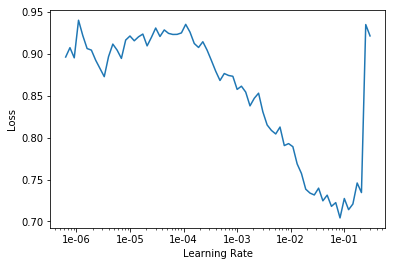

In [85]:
learn.lr_find()
learn.recorder.plot()

In [86]:
max_lr = 1e-2 

lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,error_rate
1,0.226780,0.235194,0.050893
2,0.188994,0.168991,0.060639
3,0.130352,0.147958,0.040065
4,0.123256,0.136035,0.040606
5,0.073766,1.418451,0.056849


In [ ]:
#Urgh - lets relook at this
#20181231 - parking here

In [ ]:
# best valid loisss without L/R image aug: 0.114186

Pretty small, but some improvement over Resnet34

In [37]:
learn.save(f'{MODEL_NAME}_stage-1-50')

In [38]:
learn.load(f'{MODEL_NAME}_stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (6970 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: ../input/train_300_bp_500Hz-40MHz
x: ImageItemList (6970 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_bp_500Hz-40MHz;

Valid: LabelList
y: CategoryList (1742 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input/train_300_bp_500Hz-40MHz
x: ImageItemList (1742 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_bp_500Hz-40MHz;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilati

In [39]:
learn.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


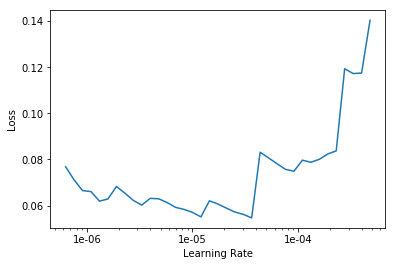

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(5, max_lr=3e-6)

epoch,train_loss,valid_loss,error_rate
1,0.105433,0.116410,0.042480
2,0.110489,0.109507,0.035017
3,0.081871,0.106712,0.035591
4,0.062753,0.104238,0.035591
5,0.064688,0.104903,0.035591


In [29]:
learn.save(f'{MODEL_NAME}_stage-2-50')

In [42]:
interp = ClassificationInterpretation.from_learner(learn)

In [43]:
interp.most_confused(min_val=2)

[(1, 0, 42), (0, 1, 20)]

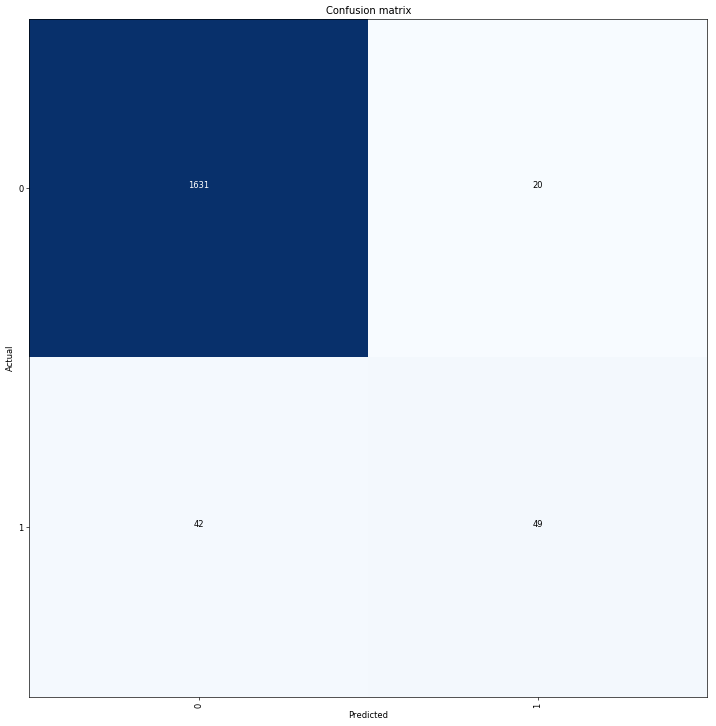

In [44]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
### Predict 20181231 - up to here

In [34]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [35]:
df_sub_50_u=pd.DataFrame.from_dict(d, orient='index')

In [36]:
df_sub_50_u=df_sub_50_u.reset_index()


In [37]:
df_sub_50_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_50_u.head()

,signal_id,target
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [38]:
df_sub_50_u.to_csv(path/f'submissions/submission_{MODEL_NAME}_resnet-50_unfeeze-2-2_{DATE}_{UID}.csv', index=False)